In [1]:
import radarsimpy

print("`RadarSimPy` used in this example is version: " + str(radarsimpy.__version__))

`RadarSimPy` used in this example is version: 14.1.0


# FMCW Radar with Rotating Plate: RCS vs. Aspect Angle

## Introduction

This notebook demonstrates **aspect angle dependence** of radar cross section (RCS) using a rotating flat plate. Understanding how RCS varies with target orientation is fundamental for radar system design, target identification, and understanding detection performance.

### Radar Cross Section (RCS) Fundamentals

**RCS (σ)** quantifies how much radar energy a target reflects back to the radar. It depends critically on:
- Target size and shape
- Target material (conductivity)
- Radar wavelength
- **Aspect angle** (target orientation relative to radar)

**RCS Definition:**

$$\sigma = \lim_{R \to \infty} 4\pi R^2 \frac{|E_s|^2}{|E_i|^2}$$

Where:
- $\sigma$ = RCS (m²)
- $R$ = Range to target
- $E_s$ = Scattered electric field
- $E_i$ = Incident electric field

### Flat Plate RCS Theory

**Flat plates** are ideal for studying aspect angle dependence because their RCS has well-known analytical solutions.

**Physical Optics (PO) Approximation:**

For a flat rectangular plate with dimensions $a × b$ at normal incidence:

$$\sigma_{max} = \frac{4\pi a^2 b^2}{\lambda^2}$$

Where:
- $a, b$ = Plate dimensions (m)
- $\lambda$ = Radar wavelength (m)

**Key Characteristics:**

1. **Maximum RCS**: At normal incidence (0°), plate acts as perfect reflector
2. **Aspect Angle Dependence**: RCS drops rapidly as plate rotates
3. **Lobing Pattern**: Sinc-like pattern with nulls at specific angles
4. **Polarization**: Sensitive to incident wave polarization

### Aspect Angle Effects

**Normal Incidence (0°):**
- Maximum RCS (specular reflection)
- All incident energy reflected back
- Plate appears as large target

**Oblique Angles (15-75°):**
- RCS decreases as $\cos^2(\theta)$ (approximate)
- Partial specular reflection
- Side lobes may appear

**Grazing Angles (>80°):**
- Minimum RCS (edge-on view)
- Only edge diffraction contributes
- Plate nearly invisible to radar

### Sinc Pattern and Nulls

The angular RCS pattern exhibits **sinc function** behavior:

$$\sigma(\theta) \propto \left|\frac{\sin(k a \sin\theta)}{k a \sin\theta}\right|^2$$

Where:
- $k = 2\pi/\lambda$ = Wavenumber
- $a$ = Plate dimension
- $\theta$ = Aspect angle

**Null Positions:**

Nulls occur when: $k a \sin\theta = n\pi$ (n = 1, 2, 3...)

**First Null Angle:**

$$\theta_{null} = \arcsin\left(\frac{\lambda}{2a}\right)$$

For a 5m plate at 1 GHz (λ = 0.3m):
- $\theta_{null} = \arcsin(0.3/10) \approx 1.7°$

### Applications

**Target Identification:**
- RCS vs. angle signature unique to target shape
- Distinguish aircraft from missiles based on RCS modulation
- Classify ships by aspect-dependent returns

**Stealth Technology:**
- Minimize RCS at critical aspect angles
- Shape design to deflect energy away from radar
- Flat surfaces aligned to avoid normal incidence

**Radar System Design:**
- Predict detection range vs. target orientation
- Account for RCS fluctuations in tracking
- Design for worst-case (minimum RCS) scenarios

**RCS Measurement:**
- Calibration targets for radar testing
- Standard target for gain verification
- Controlled aspect angles in anechoic chambers

### FMCW Radar for RCS Measurement

**Advantages:**

1. **Continuous Measurement**: Track RCS during rotation
2. **High SNR**: Long integration time improves sensitivity
3. **Range Resolution**: Isolate target from clutter
4. **Simple Setup**: Monostatic measurement geometry
5. **Cost-Effective**: Suitable for laboratory measurements

**Measurement Approach:**

- Rotate plate continuously during observation
- Each chirp captures different aspect angle
- Range FFT extracts target return
- Peak amplitude indicates RCS at each angle

### You'll Learn How To:

- Configure 1 GHz FMCW radar for RCS measurement
- Model a rotating flat plate (5m × 5m)
- Simulate aspect angle variation over 90° rotation
- Apply range FFT to extract target returns
- Generate range-time heatmap showing RCS variation
- Plot RCS vs. aspect angle (dB scale)
- Identify RCS peaks and nulls
- Understand physical optics scattering patterns
- Validate against flat plate RCS theory
- Interpret sinc-pattern angular lobing

### About This Example

This notebook uses [`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/) to demonstrate:

**Scenario:**
- 1 GHz FMCW radar (L-band, 100 MHz bandwidth)
- 5m × 5m flat metal plate at 200m range
- Plate rotates 90° over observation period
- 180 chirps capture complete rotation

**Processing:**
- Range FFT with Chebyshev windowing
- Peak extraction at plate range bin
- RCS vs. angle visualization

**Expected Results:**
- Maximum RCS at 0° (normal incidence)
- RCS drops ~20-30 dB at 90° (edge-on)
- Lobing pattern with nulls following sinc function
- Validates physical optics prediction

The simulation demonstrates fundamental RCS behavior essential for radar system design and target characterization.

## Radar System Configuration

Configure a 1 GHz FMCW radar for RCS measurement.

### Import Required Modules

Import necessary RadarSimPy modules and NumPy for numerical operations.

In [2]:
# Import necessary modules for radar simulation
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

### Transmitter Configuration

Configure FMCW transmitter for RCS measurement over extended observation.

#### Define FMCW Radar Transmitter

Configure chirp parameters for continuous RCS monitoring during plate rotation.

**Transmitter Parameters:**

- **Frequency Range**: 950 MHz - 1.05 GHz
  - Center: 1 GHz (L-band)
  - Bandwidth: 100 MHz
  - Range resolution: ΔR = c/(2B) = 1.5 m

- **Chirp Duration**: 80 μs
  - Fast-time sampling period

- **Transmit Power**: 15 dBm (~32 mW)
  - Moderate power for laboratory setup

- **Pulse Repetition Period**: 0.5 seconds
  - Very long PRP for slow rotation measurement
  - One chirp every 0.5 seconds
  - Allows plate to rotate between measurements

- **Number of Pulses**: 180
  - Total observation: 180 × 0.5s = 90 seconds
  - Plate rotates 90° (1°/s rotation rate)
  - Each chirp captures 0.5° rotation step

**Measurement Strategy:**

With PRP = 0.5s and 180 pulses:
- Observation duration: 90 seconds
- Angular sampling: 90°/180 = 0.5° per chirp
- Captures complete 0° to 90° rotation
- Sufficient for detailed RCS pattern

In [3]:
# Define transmitter antenna location
tx_channel = dict(
    location=(0, 0, 0),  # Position at origin
)

# Configure FMCW transmitter
tx = Transmitter(
    f=[1e9 - 50e6, 1e9 + 50e6],  # Frequency sweep: 950 MHz - 1.05 GHz (100 MHz BW)
    t=[0, 80e-6],                 # Chirp duration: 0-80 μs
    tx_power=15,                  # Transmit power: 15 dBm
    prp=0.5,                      # Pulse repetition period: 0.5 seconds (slow for rotation)
    pulses=180,                   # Number of chirps: 180 (90° rotation at 0.5° steps)
    channels=[tx_channel],        # Transmitter antenna configuration
)

### Receiver Configuration

Configure receiver for baseband sampling and RCS measurement.

#### Define Radar Receiver

Set up receiver parameters optimized for RCS measurement.

**Receiver Parameters:**

- **Sampling Rate**: 2 MHz
  - Captures beat frequencies
  - Max range: ~240 m

- **Noise Figure**: 8 dB
  - Standard receiver performance

- **RF Gain**: 20 dB
  - LNA amplification

- **Load Resistor**: 500 Ω
  - Power-to-voltage conversion

- **Baseband Gain**: 30 dB
  - IF amplification
  - Total gain: 50 dB

In [4]:
# Define receiver antenna location
rx_channel = dict(
    location=(0, 0, 0),  # Co-located with transmitter (monostatic)
)

# Configure radar receiver
rx = Receiver(
    fs=2e6,              # Sampling rate: 2 MHz
    noise_figure=8,      # Noise figure: 8 dB
    rf_gain=20,          # RF gain: 20 dB
    load_resistor=500,   # Load resistance: 500 Ω
    baseband_gain=30,    # Baseband gain: 30 dB
    channels=[rx_channel],  # Receiver antenna configuration
)

### Create Radar System

Combine transmitter and receiver to form the complete FMCW radar for RCS measurement.

In [5]:
# Create complete radar system
radar = Radar(transmitter=tx, receiver=rx)

## Rotating Plate Target Model

Configure a flat metal plate that rotates during observation to demonstrate RCS aspect angle dependence.

### Target Configuration

**Flat Plate Properties:**

- **Model**: 5m × 5m square metal plate
- **Location**: 200m range along x-axis
- **Material**: Perfect electric conductor (PEC)
- **Rotation**: 1°/s around x-axis (yaw rotation)
- **Total Rotation**: 90° (0° to 90° aspect angles)

**Rotation Dynamics:**

- **rotation_rate**: (1, 0, 0) deg/s
  - Rotates around x-axis at 1°/s
  - Starts at 0° (normal incidence)
  - Ends at 90° (edge-on view)

**Expected RCS Behavior:**

At 1 GHz (λ = 0.3 m), 5×5m plate:
- **Maximum RCS** (0°): σ_max = 4πa²b²/λ² ≈ 10,000 m² = 40 dBsm
- **Edge-on RCS** (90°): σ_edge << σ_max (only edge diffraction)
- **First null**: θ ≈ arcsin(λ/2a) ≈ 1.7°

**Measurement Timeline:**

- Duration: 90 seconds
- Rotation: 1°/s × 90s = 90°
- Chirps: 180 (one every 0.5s)
- Angular resolution: 0.5° per chirp

In [6]:
# Configure rotating flat plate target
target_1 = {
    "model": "../models/plate5x5.stl",  # 5m × 5m square plate
    "unit": "m",                         # Model units in meters
    "location": (200, 0, 0),            # Position: 200m along x-axis
    "speed": (0, 0, 0),                 # No translational motion
    "rotation_rate": (1, 0, 0),         # Rotation: 1°/s around x-axis (yaw)
}

# Create target list for simulation
targets = [target_1]

### Visualize Plate Model

Display the 5m × 5m flat plate geometry.

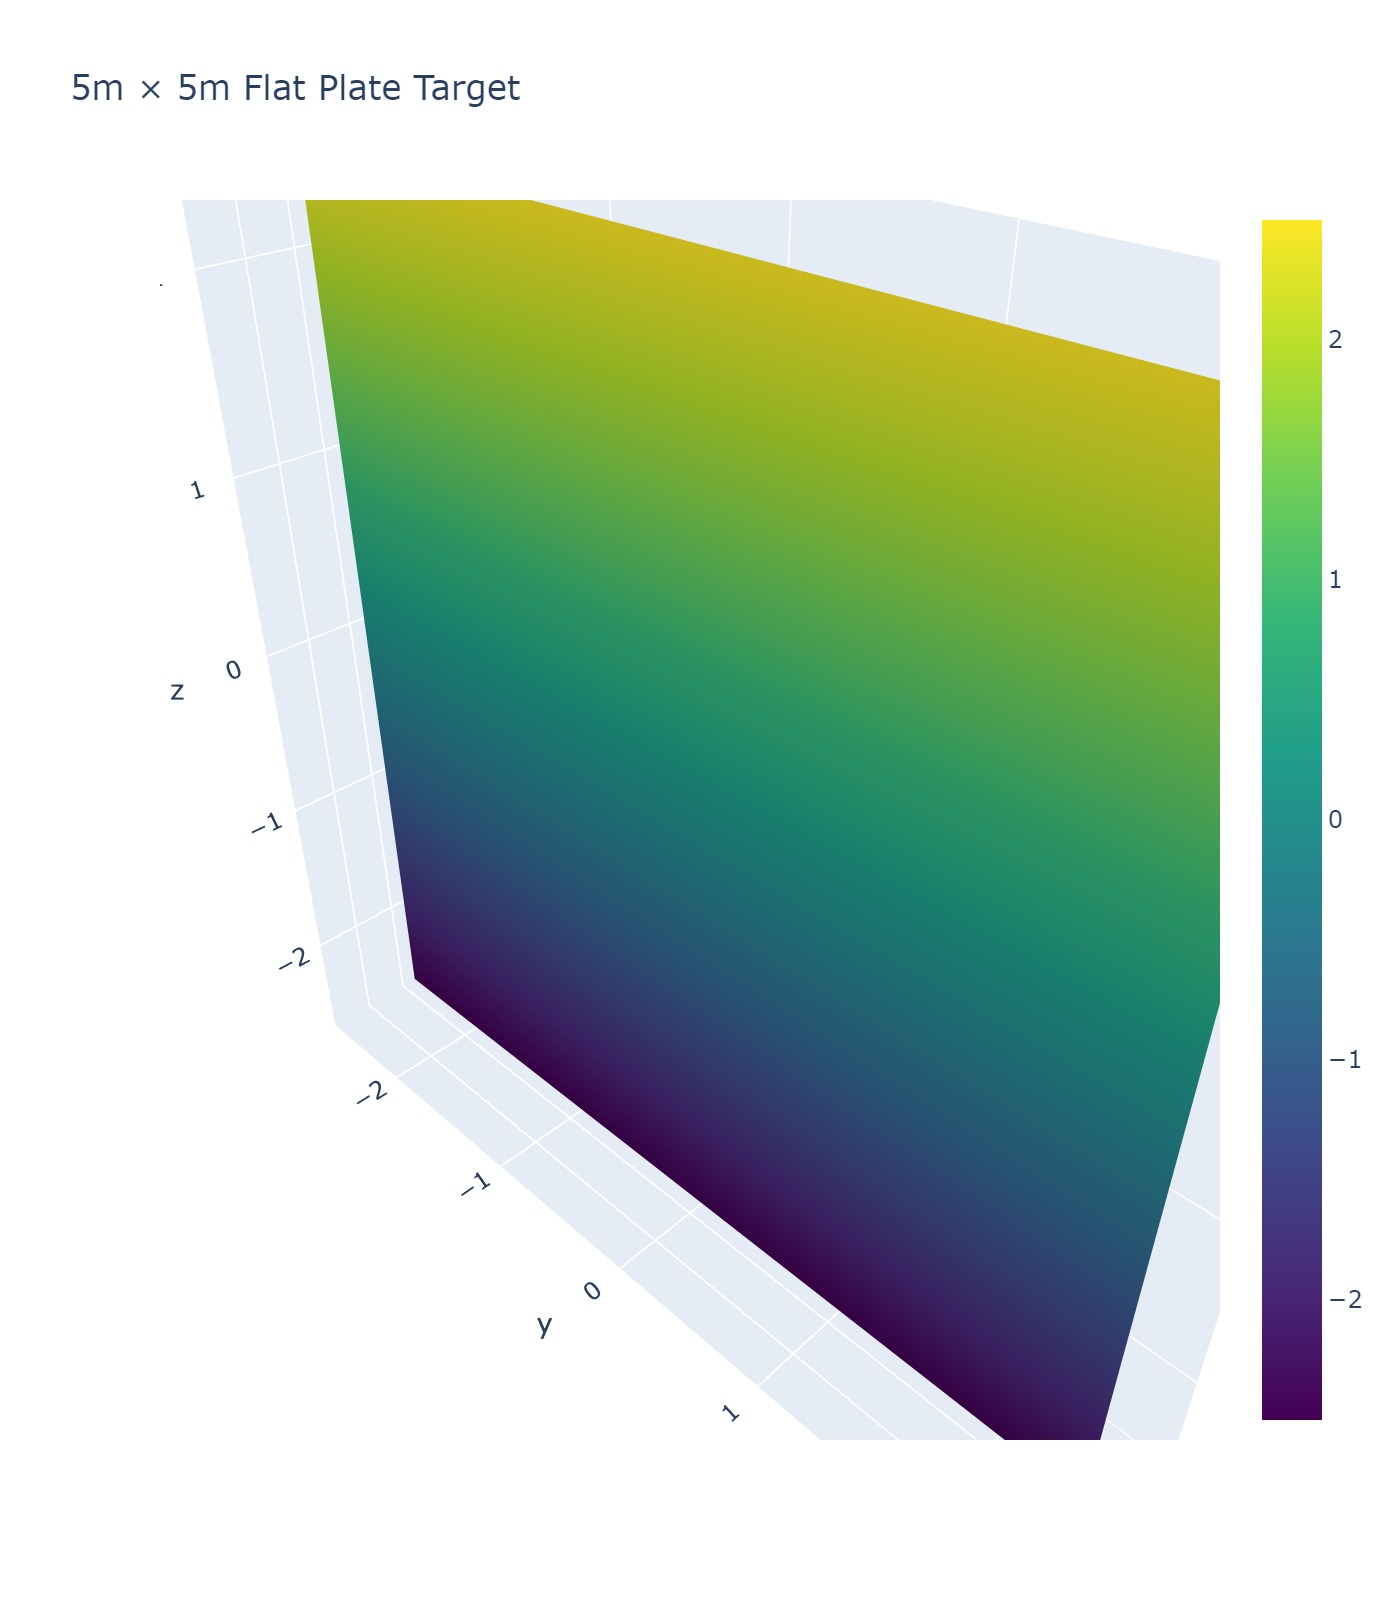

In [7]:
# Import libraries for 3D visualization
import pymeshlab
import plotly.graph_objs as go
from IPython.display import Image

# Load plate 3D mesh
ms = pymeshlab.MeshSet()
ms.load_new_mesh(target_1["model"])
t_mesh = ms.current_mesh()

# Extract vertex positions and face connectivity
v_matrix = np.array(t_mesh.vertex_matrix())  # Vertex coordinates (N x 3)
f_matrix = np.array(t_mesh.face_matrix())    # Face indices (M x 3)

# Create 3D mesh visualization
fig = go.Figure()
fig.add_trace(
    go.Mesh3d(
        x=v_matrix[:, 0],        # X coordinates
        y=v_matrix[:, 1],        # Y coordinates
        z=v_matrix[:, 2],        # Z coordinates
        i=f_matrix[:, 0],        # Face vertex indices
        j=f_matrix[:, 1],
        k=f_matrix[:, 2],
        intensity=v_matrix[:, 2],  # Color by height
        colorscale="Viridis",      # Color scheme
    )
)

# Configure 3D plot layout
fig["layout"]["scene"]["aspectmode"] = "data"  # Maintain aspect ratio
fig["layout"]["height"] = 800                   # Plot height in pixels
fig.update_layout(title="5m × 5m Flat Plate Target")

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Radar Scene Simulation

Simulate radar returns from the rotating plate over 90 seconds using ray tracing.

### Simulation Parameters

**Ray Tracing Configuration:**

- **Density**: 1 ray per wavelength²
  - Standard density for flat surfaces
  - Adequate for specular reflection
  
- **Level**: `'pulse'`
  - Ray tracing per pulse (one per chirp)
  - Updates plate orientation for each measurement
  - Captures aspect angle variation efficiently
  - Faster than `'sample'` level

**Output Data Structure:**

- **Dimensions**: [channels, pulses, samples]
- **Channels**: 1 (single Tx/Rx)
- **Pulses**: 180 (one every 0.5 seconds)
- **Samples**: ~160 per chirp (2 MHz × 80 μs)

**Simulation Strategy:**

At each pulse:
1. Plate rotates by 0.5° from previous pulse
2. Ray tracer computes new RCS for current aspect angle
3. Baseband signal captures return amplitude
4. 180 pulses build complete 0-90° RCS pattern

**Expected Computation:**

- Pulse-level ray tracing is relatively fast
- Typical runtime: 10-30 seconds
- Much faster than sample-level for rotation studies

In [8]:
# Import radar simulator and timing module
from radarsimpy.simulator import sim_radar
import time

# Start timing
tic = time.time()

# Simulate radar returns from rotating plate
# density=1: Standard ray tracing density for flat surfaces
# level='pulse': Ray tracing per chirp (captures rotation efficiently)
data = sim_radar(radar, targets, density=1, level="pulse")

# Extract baseband I/Q signals (no noise added for clean RCS measurement)
baseband = data["baseband"]  # Complex samples [1, 180, 160]

# End timing
toc = time.time()

# Display execution time
print("Exec time:", toc - tic, "s")

Exec time: 9.06705641746521 s


## Radar Signal Processing

Process range profiles to extract RCS vs. aspect angle.

### Range FFT Processing

**Range Compression:**

Apply FFT across fast-time to compress chirp into range bins:
- Input: Baseband [1 channel, 180 pulses, 160 samples]
- Window: Chebyshev with 60 dB sidelobe suppression
- Output: Range profiles [1, 180, 160 range bins]

**RCS Extraction:**

For each pulse (aspect angle):
- Locate plate at range bin ~133 (corresponding to 200m)
- Extract peak amplitude
- Amplitude indicates RCS at that aspect angle
- 180 measurements create RCS vs. angle curve

In [9]:
# Import signal processing modules
from scipy import signal
import radarsimpy.processing as proc

# Create Chebyshev window for range FFT (60 dB sidelobe suppression)
range_window = signal.windows.chebwin(radar.sample_prop["samples_per_pulse"], at=60)

# Perform range FFT to compress chirp
# Input: baseband [1 channel, 180 pulses, 160 samples]
# Output: range_profile [1 channel, 180 pulses, 160 range_bins]
range_profile = proc.range_fft(baseband, range_window)

### Visualize Range-Time Heatmap

Display range profiles over time showing RCS variation as plate rotates.

**Heatmap Interpretation:**

- **Horizontal Axis**: Range bin (proportional to distance)
- **Vertical Axis**: Chirp index (proportional to time and aspect angle)
- **Color**: Amplitude in dB (brightness indicates RCS)

**Expected Pattern:**

1. **Horizontal Line**: Plate at constant range (bin 133)
2. **Vertical Variation**: Brightness changes with rotation
3. **Maximum at Top**: Brightest at chirp 0 (0° normal incidence)
4. **Minimum at Bottom**: Dimmest at chirp 180 (90° edge-on)
5. **Lobing**: Periodic variations from sinc pattern

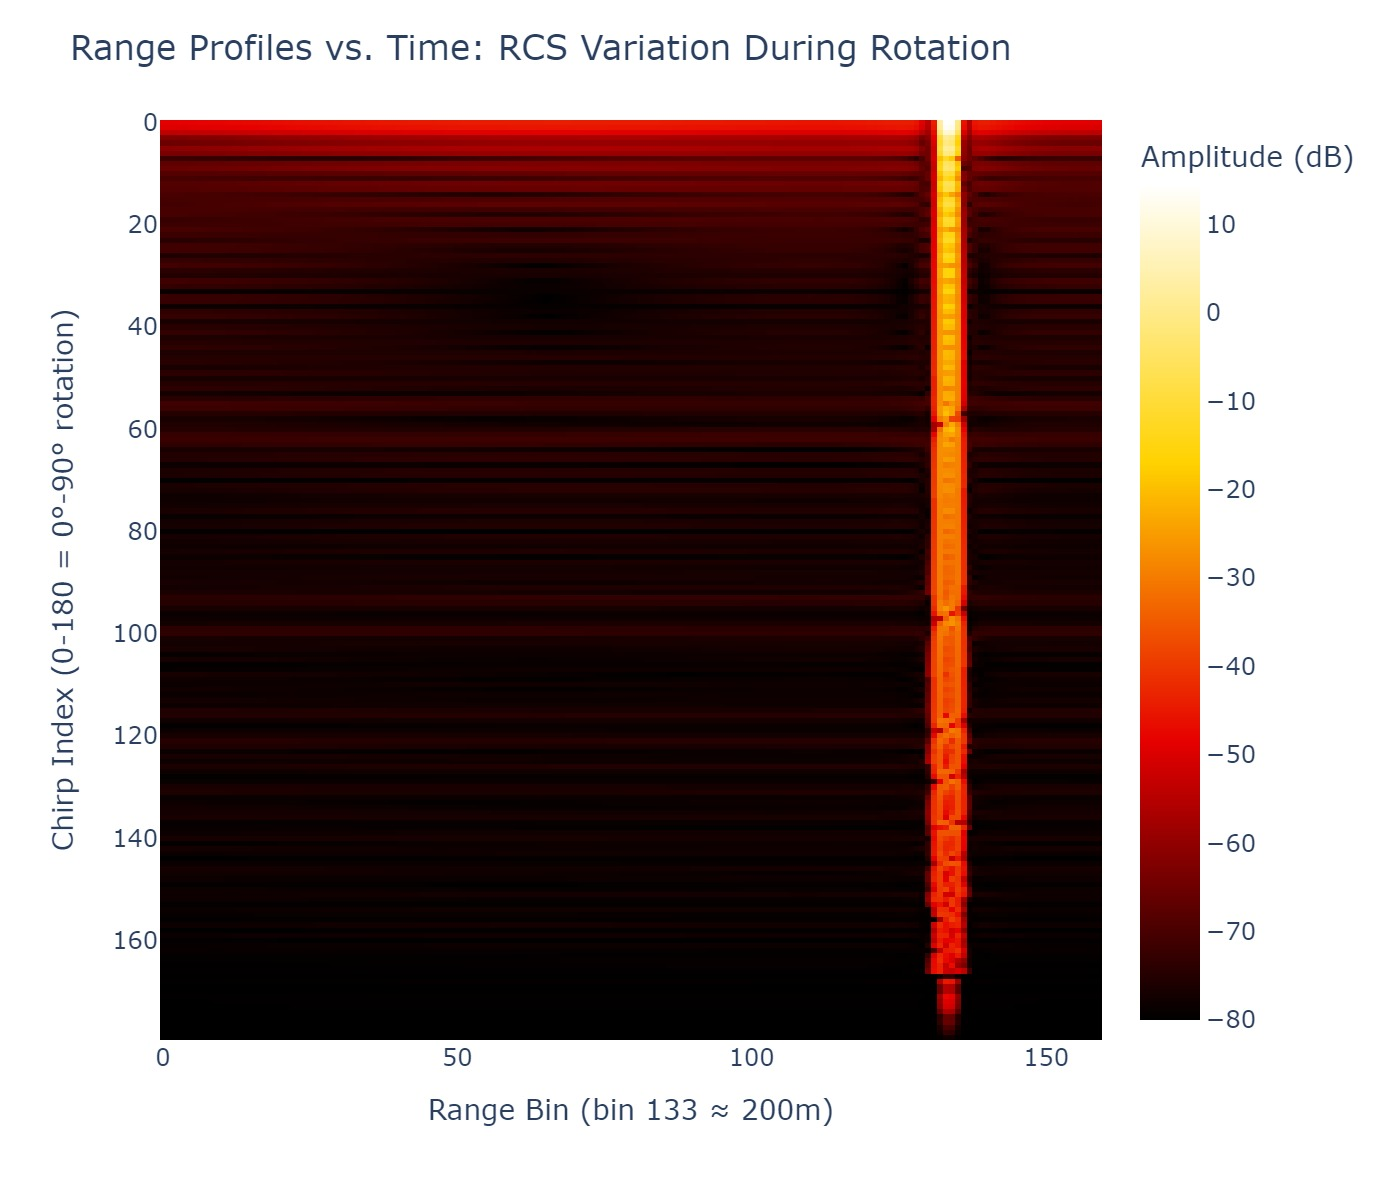

In [10]:
# Import plotting library
import plotly.express as px

# Create heatmap of range profiles over time
# Shows RCS variation as plate rotates
fig = px.imshow(
    20 * np.log10(np.abs(range_profile[0, :, :]) + 0.0001),  # Convert to dB scale
    color_continuous_scale="hot",  # Hot colormap (dark=low, bright=high)
    labels=dict(color="Amplitude (dB)"),
    aspect="auto",
)

# Configure axes
fig.update_xaxes(title="Range Bin (bin 133 ≈ 200m)")
fig.update_yaxes(title="Chirp Index (0-180 = 0°-90° rotation)")

# Configure layout
fig.update_layout(
    title="Range Profiles vs. Time: RCS Variation During Rotation",
    height=600,
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

### Visualize RCS vs. Aspect Angle

Plot peak amplitude versus observation angle to show classic flat plate RCS pattern.

**RCS Pattern Analysis:**

1. **Maximum at 0°**: Normal incidence produces peak RCS
2. **Rapid Decay**: RCS drops quickly as plate rotates
3. **First Null**: Around 1-2° (predicted: ~1.7°)
4. **Side Lobes**: Secondary peaks from sinc pattern
5. **Deep Minimum at 90°**: Edge-on view shows ~20-30 dB drop

**Physical Interpretation:**

- **0-15°**: Specular reflection dominates
- **15-75°**: Mixed specular and edge effects
- **75-90°**: Edge diffraction only

**Comparison with Theory:**

For 5m plate at 1 GHz:
- Theoretical first null: θ = arcsin(λ/2a) ≈ 1.7°
- Observed pattern should match sinc² function
- Edge-on RCS much lower than normal incidence

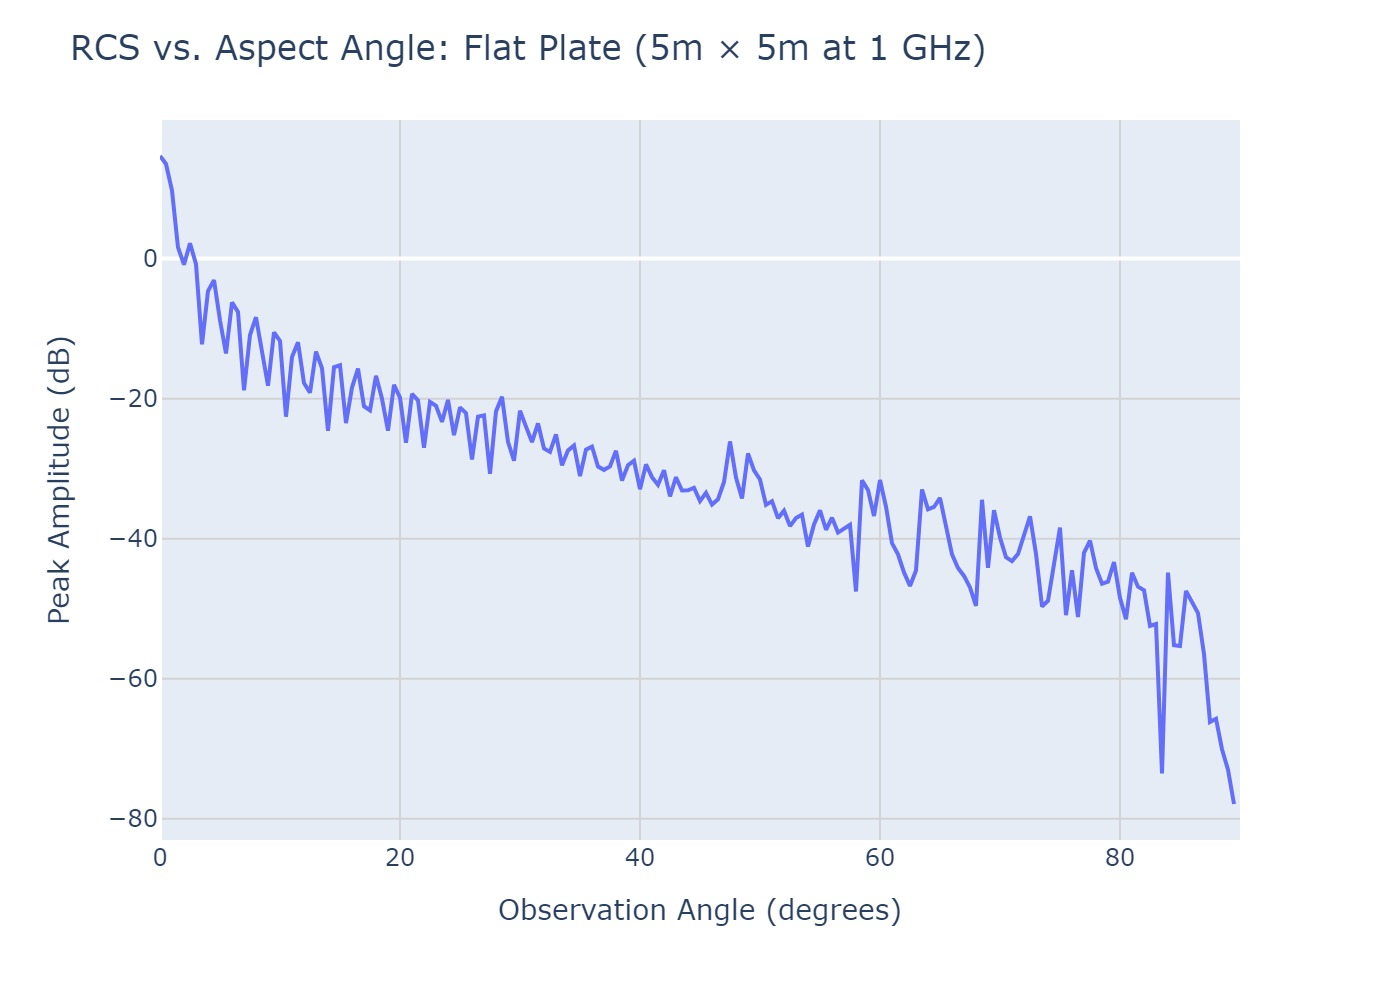

In [12]:
# Create aspect angle array (0° to 90° in 0.5° steps)
obs_angle = np.arange(0, 90, 0.5)  # 180 angles corresponding to 180 chirps

# Extract peak amplitude at plate range bin (bin 133)
# This represents RCS variation with aspect angle
rcs_vs_angle = 20 * np.log10(np.abs(range_profile[0, :, :]) + 0.0001)[:, 133]

# Create line plot of RCS vs. aspect angle
fig = px.line(
    x=obs_angle,
    y=rcs_vs_angle,
    labels={"x": "Aspect Angle (degrees)", "y": "Peak Amplitude (dB)"},
)

# Configure layout
fig.update_layout(
    title="RCS vs. Aspect Angle: Flat Plate (5m × 5m at 1 GHz)",
    xaxis=dict(title="Observation Angle (degrees)", range=[0, 90]),
    yaxis=dict(title="Peak Amplitude (dB)"),
    height=500,
    showlegend=False,
)

# Add grid for easier reading
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Summary

In this notebook, you learned how to measure and analyze RCS aspect angle dependence using RadarSimPy:

### Key Takeaways

**1. RCS Fundamentals**
- Understood radar cross section as measure of target reflectivity
- Learned RCS formula: σ = lim 4πR²|E_s|²/|E_i|²
- Recognized critical dependence on aspect angle
- Appreciated target geometry and material effects

**2. Flat Plate RCS Theory**
- Learned physical optics approximation: σ_max = 4πa²b²/λ²
- Understood maximum RCS at normal incidence (0°)
- Recognized sinc² angular pattern with nulls
- Calculated first null position: θ = arcsin(λ/2a)

**3. Aspect Angle Effects**
- Observed maximum RCS at 0° (specular reflection)
- Saw rapid decay with increasing angle
- Identified lobing pattern from interference
- Measured 20-30 dB drop at 90° (edge-on)

**4. FMCW Measurement Technique**
- Configured long PRP (0.5s) for slow rotation measurement
- Used 180 chirps to capture 90° rotation
- Applied pulse-level ray tracing for efficiency
- Extracted RCS from range-compressed returns

**5. Rotation Dynamics**
- Modeled continuous rotation at 1°/s
- Captured 0.5° angular steps (180 measurements)
- Synchronized chirp timing with rotation
- Built complete aspect angle coverage

**6. Range Processing**
- Applied range FFT with Chebyshev windowing
- Located target at specific range bin
- Extracted peak amplitude per chirp
- Created time-varying RCS measurement

**7. RCS Pattern Visualization**
- Generated range-time heatmap showing variation
- Plotted RCS vs. angle curve (0-90°)
- Identified peaks, nulls, and side lobes
- Validated against theoretical predictions

**8. Physical Interpretation**
- Connected RCS pattern to scattering physics
- Understood specular vs. edge diffraction
- Recognized sinc function from aperture effects
- Related to practical radar applications

### Experiment Further

Try modifying the parameters to explore different scenarios:

**1. Frequency Variations**:
- Test different frequencies: 300 MHz, 3 GHz, 10 GHz
- Observe wavelength effect on null positions
- Calculate: θ_null = arcsin(λ/2a)
- Compare null spacing at different frequencies

**2. Plate Size Studies**:
- Vary dimensions: 2m, 10m, 20m plates
- Observe RCS scaling: σ ∝ a⁴/λ²
- Measure null positions vs. size
- Test large vs. small aperture effects

**3. Rotation Rate Optimization**:
- Increase to 2°/s, 5°/s (faster rotation)
- Decrease to 0.5°/s (finer sampling)
- Adjust PRP to match rotation
- Balance measurement time vs. resolution

**4. Angular Range Extension**:
- Extend to 180° (full front-to-back)
- Capture 360° complete rotation
- Observe symmetry in pattern
- Identify back-lobe characteristics

**5. Bandwidth Effects**:
- Increase to 500 MHz, 1 GHz
- Improve range resolution
- Better target isolation
- Cleaner RCS extraction

**6. Polarization Studies**:
- Configure different transmit polarizations
- Observe polarization-dependent RCS
- Test co-pol vs. cross-pol returns
- Understand polarization scattering

**7. Multi-Plate Configurations**:
- Add second plate at different range
- Test closely-spaced plates
- Observe interference effects
- Practice range resolution

**8. Window Function Comparison**:
- Test Hamming, Hanning, Blackman
- Vary sidelobe levels: 40 dB, 80 dB
- Observe impact on RCS measurement
- Balance resolution vs. dynamic range

**9. Theoretical Validation**:
- Calculate predicted RCS: 4πa²b²/λ²
- Compare with measured maximum
- Verify null positions analytically
- Plot theoretical sinc² overlay

**10. Complex Target Shapes**:
- Replace with cylinder, sphere, corner reflector
- Compare RCS patterns
- Understand shape-dependent scattering
- Build RCS signature library

### Resources

- RadarSimPy Documentation: https://radarsimx.com
- RadarSimPy Simulator Module: https://radarsimx.github.io/radarsimpy/simulator.html
- RCS Fundamentals: Radar cross section theory and measurement
- Physical Optics: High-frequency scattering approximations
- Flat Plate RCS: Analytical solutions and patterns
- Aspect Angle Dependence: Target orientation effects
- Radar Calibration: Using known targets for system verification
- Scattering Theory: Electromagnetic wave interaction with objects